In [1]:
from datasets import Dataset
import pandas as pd
import evaluate
import numpy as np
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, AutoTokenizer, set_seed
import os
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import argparse
import logging
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import wandb
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import os
from torch.utils.data import Dataset
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from datasets import Dataset
import numpy as np
import numpy as np
from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from transformers import AutoConfig, RobertaModel, RobertaForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput
import pandas as pd,os
import torch
from statistics import mode
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline, Trainer
from datasets import Dataset, load_metric
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import pickle
from transformers import RobertaConfig, RobertaModel
import torch
from torch import nn
import torch
from torch import nn
from transformers import AutoConfig, RobertaModel, RobertaForSequenceClassification
from transformers.modeling_outputs import SequenceClassifierOutput
from typing import Optional, Union, Tuple
from datasets import Dataset
import pandas as pd
import evaluate
import numpy as np
from transformers import EarlyStoppingCallback,AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding, AutoTokenizer, set_seed
import os
from sklearn.model_selection import train_test_split
from scipy.special import softmax
import argparse
import logging
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import wandb
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import os
from torch.utils.data import Dataset
import torch
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from datasets import Dataset
import numpy as np
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize
from textstat.textstat import textstatistics
import pandas as pd
import language_tool_python
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.metrics import precision_score, recall_score, roc_auc_score, confusion_matrix
import numpy as np
from itertools import combinations
from sklearn.ensemble import RandomForestClassifier

c:\Users\Ghiki\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, num_extra_dims):
        super().__init__()
        total_dims = config.hidden_size+num_extra_dims
        self.dense = nn.Linear(total_dims, total_dims)
        classifier_dropout = (
            config.classifier_dropout if config.classifier_dropout is not None else config.hidden_dropout_prob
        )
        self.dropout = nn.Dropout(classifier_dropout)
        self.out_proj = nn.Linear(total_dims, config.num_labels)

    def forward(self, features, **kwargs):
        x = self.dropout(features)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        x = self.out_proj(x)
        return x

class CustomSequenceClassification(RobertaForSequenceClassification):

    def __init__(self, config, num_extra_dims):
        super().__init__(config)
        self.num_labels = config.num_labels
        self.config = config

        # might need to rename this depending on the model
        self.roberta =  RobertaModel(config)
        self.classifier = ClassificationHead(config, num_extra_dims)

        # Initialize weights and apply final processing
        self.post_init()

    
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        extra_data: Optional[torch.FloatTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        head_mask: Optional[torch.FloatTensor] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
    ) -> Union[Tuple, SequenceClassifierOutput]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.roberta(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        # sequence_output will be (batch_size, seq_length, hidden_size)
        sequence_output = outputs[0]

        # additional data should be (batch_size, num_extra_dims)
        cls_embedding = sequence_output[:, 0, :]

        output = torch.cat((cls_embedding, extra_data), dim=-1)

        logits = self.classifier(output)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = nn.MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = nn.BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + outputs[2:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [3]:
df = pd.read_json('datasets/subtaskB_test.jsonl', lines=True)

print(f'Original dataset')
print(df.info())


df = df[['text']]
test_df=df

test_texts = test_df['text'].tolist()

Original dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    18000 non-null  object
 1   id      18000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 281.4+ KB
None


In [4]:
MODEL1 = 'bert-base-uncased'
MODEL2 = 'roberta-base'
MODEL3 = 'distilbert-base-uncased'
MODEL4 = 'google/electra-base-discriminator'
MODEL5 = 'albert-base-v2'
MODEL6 = 'multimodal-roberta-base'
MODEL7 = 'multimodal-extended-roberta-base'

MODEL_PATH1='SavedModels/optimized-bert-base-uncased-50k'
MODEL_PATH2='SavedModels/optimized-roberta-base-30k'
MODEL_PATH3='SavedModels/optimized-distilbert-base-uncased-50k'
MODEL_PATH4='SavedModels/optimized-electra-base-discriminator-50k'
MODEL_PATH5='SavedModels/optimized-albert-base-v2-15k'
MODEL_PATH6='SavedModels/optimized-roberta-base-multimodal-70k'
MODEL_PATH7='SavedModels/optimized-roberta-base-multimodal-extended-70k'

'''Preparing data'''

df = pd.read_json('datasets/subtaskB_test.jsonl', lines=True)

print(f'Original dataset')
print(df.info())

df = df[['text']]
test_df=df

test_texts = test_df['text'].tolist()

from scipy.special import expit

def getPrediction(model_path):
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    id2label = {0: 'human', 1: 'chatGPT', 2: 'cohere', 3: 'davinci', 4: 'bloomz', 5: 'dolly'}
    label2id = {'human': 0, 'chatGPT': 1,'cohere': 2, 'davinci': 3, 'bloomz': 4, 'dolly': 5}
    model = AutoModelForSequenceClassification.from_pretrained(
        model_path, num_labels=len(label2id), id2label=id2label, label2id=label2id
        )

    test_dataset = Dataset.from_pandas(test_df)

    def preprocess_function(examples, **fn_kwargs):
        return fn_kwargs['tokenizer'](examples["text"], truncation=True)

    tokenized_test_dataset = test_dataset.map(preprocess_function, batched=True,  fn_kwargs={'tokenizer': tokenizer})
    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

    # create Trainer
    trainer = Trainer(
        model=model,
        tokenizer=tokenizer,
        data_collator=data_collator,
        # compute_metrics=compute_metrics,
    )
    # get logits from predictions and evaluate results using classification report
    predictions = trainer.predict(tokenized_test_dataset)
    probs = expit(predictions.predictions)  # Use sigmoid instead of softmax
    preds = np.argmax(predictions.predictions, axis=-1)

    return preds, probs

def getPredictionMultidomain(model_path,num_extra_dims,test_data):
    config = RobertaConfig.from_pretrained(model_path)
    model = CustomSequenceClassification(config, num_extra_dims)
    model.load_state_dict(torch.load(model_path+'/pytorch_model.bin'))
    trainer = Trainer(model=model)
    # get logits from predictions and evaluate results using classification report
    predictions = trainer.predict(test_data)
    probs = expit(predictions.predictions)  # Use sigmoid instead of softmax
    preds = np.argmax(predictions.predictions, axis=-1)

    return preds, probs

# print(f'\nProcessing with {MODEL1}')
# labels1,scores1=getPrediction(MODEL_PATH1)

print(f'\nProcessing with {MODEL2}')
labels2,scores2=getPrediction(MODEL_PATH2)

# print(f'\nProcessing with {MODEL3}')
# labels3,scores3=getPrediction(MODEL_PATH3)

# print(f'\nProcessing with {MODEL4}')
# labels4,scores4=getPrediction(MODEL_PATH4)

# print(f'\nProcessing with {MODEL5}')
# labels5,scores5=getPrediction(MODEL_PATH5)

df_multidomain_extended_extraData=pd.read_csv('datasets/features_df_test_B.csv')

reduced_columns=['word_count','avg_sentence_length','avg_word_length','gunning_fog_index','grammatical_errors']
df_multidomain_extraData=df_multidomain_extended_extraData[reduced_columns]

# df_multidomain_extraData=df_multidomain.drop(['label'],axis=1)
# df_multidomain_extraData=df_multidomain.drop(['text'],axis=1)

# df_multidomain_extended_extraData=df_multidomain_extended.drop(['label'],axis=1)
# df_multidomain_extended_extraData=df_multidomain_extended.drop(['text'],axis=1)

ds_test = Dataset.from_dict({
        "text": test_df['text'].tolist(), 
        "extra_data": df_multidomain_extraData.values.tolist(),
        # "labels": df_multidomain['label'].tolist()
    })

ds_test_extended = Dataset.from_dict({
        "text": test_df['text'].tolist(), 
        "extra_data": df_multidomain_extended_extraData.values.tolist(),
        # "labels": df_multidomain_extended['label'].tolist()
    })

tokenizer = AutoTokenizer.from_pretrained('roberta-base')
# tokenized_ds_test_extended = ds_test_extended.map(lambda x: tokenizer(x["text"], padding='max_length', truncation=True))
# tokenized_ds_test_extended = tokenized_ds_test_extended.map(lambda x: {'extra_data': x['extra_data']})

tokenized_ds_test = ds_test.map(lambda x: tokenizer(x["text"], padding='max_length', truncation=True))
tokenized_ds_test = tokenized_ds_test.map(lambda x: {'extra_data': x['extra_data']})

print(f'\nProcessing with {MODEL6}')
labels6,scores6=getPredictionMultidomain(MODEL_PATH6,5,tokenized_ds_test)

# print(f'\nProcessing with {MODEL7}')
# labels7,scores7=getPredictionMultidomain(MODEL_PATH7,9,tokenized_ds_test_extended)

# scores1 = [scores1[i][labels1[i]] for i in range(len(labels1))]
scores2 = [scores2[i][labels2[i]] for i in range(len(labels2))]
# scores3 = [scores3[i][labels3[i]] for i in range(len(labels3))]
# scores4 = [scores4[i][labels4[i]] for i in range(len(labels4))]
# scores5 = [scores5[i][labels5[i]] for i in range(len(labels5))]
scores6 = [scores6[i][labels6[i]] for i in range(len(labels6))]
# scores7 = [scores7[i][labels7[i]] for i in range(len(labels7))]

Original dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    18000 non-null  object
 1   id      18000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 281.4+ KB
None

Processing with roberta-base


Map: 100%|██████████| 18000/18000 [00:03<00:00, 5878.30 examples/s]
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
Map: 100%|██████████| 18000/18000 [00:00<00:00, 27016.34 examples/s]



Processing with multimodal-roberta-base


100%|██████████| 2250/2250 [01:27<00:00, 25.63it/s]


In [8]:
models = [MODEL2, MODEL6]

df_reduced = pd.DataFrame({
    f'Labels_{MODEL2}': labels2,
    f'Scores_{MODEL2}': scores2,
    f'Labels_{MODEL6}': labels6,
    f'Scores_{MODEL6}': scores6,
})

def ensemble_methods(df, models):
    def majority_voting(df, models):
        """ Majority Voting Ensemble """
        votes = df[[f'Labels_{m}' for m in models]].mode(axis=1)
        return votes[0]

    
    return {
        'Majority Voting':majority_voting(df, models),
    }

ensemble_results = ensemble_methods(df_reduced, models)

# for voting_method, details in ensemble_results.items():
#     print(f'''{voting_method}: {getMetrics(details,labels)['accuracy']}''')

In [10]:
ensemble_results['Majority Voting']

0        4.0
1        0.0
2        4.0
3        5.0
4        5.0
        ... 
17995    0.0
17996    3.0
17997    4.0
17998    1.0
17999    0.0
Name: 0, Length: 18000, dtype: float64

In [11]:
result_labels=ensemble_results['Majority Voting']
df = pd.read_json('datasets/subtaskB_test.jsonl', lines=True)
df['id']

0            0
1            1
2            2
3            3
4            4
         ...  
17995    17995
17996    17996
17997    17997
17998    17998
17999    17999
Name: id, Length: 18000, dtype: int64

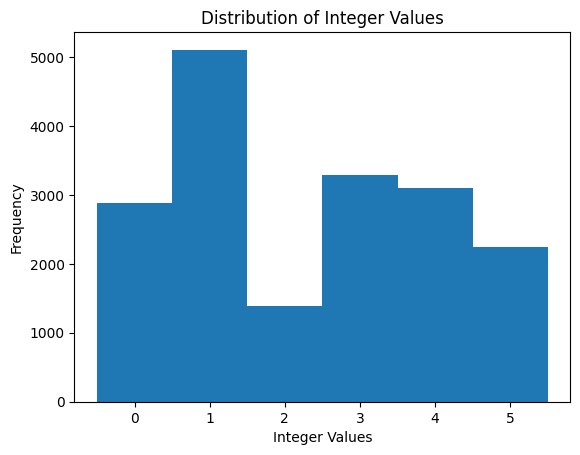

In [12]:
import matplotlib.pyplot as plt
result_labels = [int(num) for num in result_labels]

# Display the distribution of integer values
plt.hist(result_labels, bins=range(min(result_labels), max(result_labels) + 2), align='left')
plt.xlabel('Integer Values')
plt.ylabel('Frequency')
plt.title('Distribution of Integer Values')
plt.show()

In [13]:
new_df = pd.DataFrame({
    'id': df['id'],
    'label': result_labels
})

# Exporting to a jsonl file
new_df.to_json('datasets/subtask_b_results.json', orient='records', lines=True)